# Quickstart tutorial

This document helps you get up-and-running with `alr` immediately. It should give you a general idea of how to get started with this package.

## Introduction

In this document, we will use `alr` to run a simple active learning experiment on MNIST. The goal of this experiment is to show the effectiveness of using a proper acquisition function over randomly sampling unlabelled points (often referred to as random acquisition). The model is more likely to improve with fewer acquisitions when using a good acquisition function.

## Loading and preparing datasets

In this section, we define some training hyperparameters, create data loaders, and define the experiment function which we will reuse for different acquisition functions.

In [ ]:
%matplotlib inline
import torch
import torch.utils.data as torchdata
import matplotlib.pyplot as plt
from torch.nn import functional as F

from alr import MCDropout
from alr.acquisition import BALD, RandomAcquisition
from alr.data import DataManager, UnlabelledDataset
from alr.data.datasets import Dataset
from alr.training import Trainer
from alr.training.samplers import RandomFixedLengthSampler
from alr.utils import manual_seed, eval_fwd_exp, timeop

# reproducibility
manual_seed(42, det_cudnn=False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
kwargs = dict(num_workers=4, pin_memory=True)

# ========= CONSTANTS ===========
BATCH_SIZE = 64
EPOCHS = 50
VAL_SIZE = 5_000
ITERS = 21
BATCH_ACQUIRE_SIZE = 10

# ========= SETUP ===========
train, pool, test = Dataset.MNIST.get_fixed()
pool, val = torchdata.random_split(pool, (len(pool) - VAL_SIZE, VAL_SIZE))
pool = UnlabelledDataset(pool)

pool_loader = torchdata.DataLoader(
    pool, batch_size=1024, shuffle=False, **kwargs,
)
val_loader = torchdata.DataLoader(
    val, batch_size=1024, shuffle=False, **kwargs,
)
test_loader = torchdata.DataLoader(
    test, batch_size=1024, shuffle=False, **kwargs,
)

def run_experiment(
    model: MCDropout,
    data_manager: DataManager,
    batch_acquire_size: int,
    iterations: int,
):
    accs = []
    for i in range(1, iterations + 1):
        model.reset_weights()
        trainer = Trainer(
            model, F.nll_loss, optimiser='Adam',
            patience=3, reload_best=True, device=device
        )
        train_loader = torchdata.DataLoader(
            dm.labelled, batch_size=BATCH_SIZE,
            sampler=RandomFixedLengthSampler(dm.labelled, 12_500, shuffle=True),
            **kwargs
        )
        with timeop() as t:
            history = trainer.fit(train_loader, val_loader, epochs=EPOCHS)
    
        test_metrics = trainer.evaluate(test_loader)
    
        print(f"=== Iteration {i} of {iterations} ({i / iterations:.2%}) ===")
        print(f"\ttrain: {dm.n_labelled}; val: {len(val)}; "
            f"pool: {dm.n_unlabelled}; test: {len(test)}")

        print(f"\t[test] acc: {test_metrics['acc']:.4f}, time: {t}")

        accs.append(test_metrics['acc'])
        dm.acquire(b=batch_acquire_size)
    return accs

## Acquire the most _informative_ points using BALD

The `BALD` constructor expects the first argument to be a function that takes an input and returns a probability distribution. By wrapping our model with `eval_fwd_exp`, it returns a function that sets the model to `.eval()` mode, calls the `forward` method, and exponentiates the output (since our model returns log-softmax values).

The remaining arguments in the constructor determine how the acquisition function iterates over the `pool` dataset. Typically, this is identical to how you would construct the validation and test data loaders.


### DataManager

The `DataManager` class encapsulates the process of acquiring points from `pool`. Its two most useful methods are:

* `.acquire(b)` acquires `b` points from `pool`, labels them, and adds them into `train`.
* `.reset()` resets the `DataManager` to its initial state.

In [ ]:
model = MCDropout(Dataset.MNIST.model, forward=20, fast=True).to(device)
acq_fn = BALD(eval_fwd_exp(model), device=device, batch_size=1024, **kwargs)
dm = DataManager(train, pool, acq_fn)

bald_accs = run_experiment(
    model, dm,
    batch_acquire_size=BATCH_ACQUIRE_SIZE,
    iterations=ITERS
)

## Acquire points using random acquisition

As a baseline, we could also randomly acquire points from `pool`.

In [ ]:
dm = DataManager(train, pool, RandomAcquisition())

baseline_accs = run_experiment(
    model, dm,
    batch_acquire_size=BATCH_ACQUIRE_SIZE, iterations=ITERS
)

## Results

As expected, BALD outperforms random acquisition; it picks points that the model finds most informative. Therefore, the model requires fewer acquisitions to achieve high accuracy.

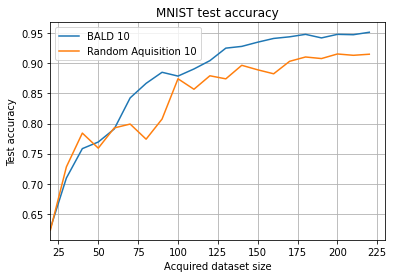

In [ ]:
plt.plot(range(20, 230, 10), bald_accs, label="BALD 10")
plt.plot(range(20, 230, 10), baseline_accs, label="Random Aquisition 10")
plt.legend()
plt.grid()
plt.title("MNIST test accuracy")
plt.xlabel("Acquired dataset size")
plt.ylabel("Test accuracy")
plt.xlim(left=20);